##    <font color='green'> STOP 1</font>    <font color='red'>       Please enter the path to the session data :</font>
   <font color='red'> ____________________________________________________________</font>

In [3]:
session = "//iss/karalis/users/nikolas.karalis/Data/FMI/Neuromod/nk50/nk50_s04_fc_fc/12_24_08/My_V4_Miniscope" #"./fake_dataset/nk56fake/session3"   # this is where you should store your dataset of videos 

   <font color='red'> ____________________________________________________________</font>

THIS IS FOR RUNNING WITHOUT PARAMETER TUNING

In [5]:
import os
import sys
from termcolor import colored


# Get the flag from the environment variable
interactive = False

dpath = os.getenv("SESSION_PATH", "")
if not dpath :
    dpath = session
    interactive = True


with open("CON", "w") as terminal:
    print(colored('Running for session : ', "cyan"), file = terminal )
    print(colored(dpath, "light_cyan"), file = terminal )


//iss/karalis/users/nikolas.karalis/Data/FMI/Neuromod/nk50/nk50_s04_fc_fc/12_24_08/My_V4_Miniscope


## Workflow

There are 5 main sections in this pipeline: Setting up, Pre-processing, Motion Correction, Initialization, and CNMF, which are composed of interative spatial update and temporal update.

![workflow](img/workflow.png)

## load modules

In [2]:
%%capture
%load_ext autoreload
%autoreload 2
import itertools as itt
import os
import sys
import re
import json

import holoviews as hv
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
from holoviews.operation.datashader import datashade, regrid
from holoviews.util import Dynamic
from IPython.core.display import display

In [ ]:
%%capture
# Suppress logs
!ffmpeg -i input.mp4 output.mp4

## set path and parameters

Set all of the parameters that control the notebook’s behavior.
Ideally, the following cell is the only part of the code the user will have to change when analyzing different datasets.
Here we briefly introduce only some of the initial parameters that are necessary to start the pipeline, and leave the discussion of specific parameters for later.

* `minian_path` is the path that contains the **minian** folder , where the minian codebase (.py files) reside.
    The default value `"."` means “current folder”, which should work in most cases, unless you want to try out another version of minian that is not in the same folder as this notebook.

* `dpath` is the folder that contains the videos to be processed.

* `interactive` controls whether interactive plots will be shown for parameters exploration.
    Interactive plotting requires CPU/memory usage, and thus could require some time (in particular, those steps where video is played).
    In principle, the user might want to visualize interactive plots during the initial parameters exploration, once the parameters are set and ready for batch processing, the user will set interactive as False to reduce processing time.

* `output_size` controls the relative size of all the plots on a scale of 0-100 percent, though it can be set to values >100 without any problem. 

* `param_save_minian` specifies the destination folder and format of the saved data.
    `dpath` is the folder path  where  the data will be saved.
    `meta_dict` is a `dictionary` that is used to construct meta data for the final labeled data structure.
    `overwrite` is a boolean value controlling whether the data is overwritten if a file already exists.
    We set it to `True` here so you can easily play with the demo multiple times, but **use caution** with this option during actual analysis.
    In addition to erasing prior data that may be important to you, overwritting data may cause compatibility issues with existing data from the same minian dataset folder.
    If you want to re-analyze a video from scratch using different parameters, it is recommended that you delete existing data first.

<div class="alert alert-info">
<strong>folder structure</strong>

The defult `meta_dict` in `param_save_minian` assumes output minian datasets are stored in heirarchiically arranged folders, as shown below:

```
mice1  
│
└───session1
│   │
│   └───minian
│       │   Y.zarr
│       │   A.zarr
│       │   ...
│   
└───session2
    │
    └───minian
```

The default value can be read as follows:
The name of the last folder (`-1`) in `dpath` (the folder that directly contains the videos) will be used to designate the value of a metadata dimension named `"session"`.
The name of the second-to-last folder (`-2`) in `dpath` will be used to designate the value for `"animal"` and so on.
Both the keys (name of metadata dimension) and values (numbers indicating which level of folder name should be used) of `meta_dict` can be modified to represent your preferred way of data storage. 
Note that the metadata are determined by the folder structure of saved minian datasets, not by those of input movie data.
</div>

In [3]:
# Set up Initial Basic Parameters#
minian_path = "."
result_path = os.path.join("C:/Users/axelle.piguet/Documents/GitHub/klab_analysis/Axelle"  , re.search(r'nk[^\\]*', dpath).group(0))
minian_ds_path = os.path.join(result_path, "result")


###################
# Define the path to the parameters file
param_file = os.path.join(minian_ds_path, "minian_parameters.json")

# Initialize the parameters dictionary
parameters = {}

# Check if the file exists before loading
if os.path.exists(param_file):
    with open(param_file, "r") as file:
        parameters = json.load(file)
        print("Parameters loaded successfully:", parameters)
    interactive = False # might want to change that during analysis
else:
    print("No parameters file found. Using default values.")
    parameters = {
    "ksize":9,#7,
    "wnd": 15,
    "noise_freq": 0.1,#0.06,
    "thres": 0.5,# 1,
    "thres_dist": 6,#10,
    "spatial_sparse_penal1":0.01,
    "temp_sparse_penal1": 0.5,#1,
    "spatial_sparse_penal2": 0.01,
    "temp_sparse_penal2": 0.5,#1
    }
    interactive = True # might want to change that during analysis
###################


# ADD INPUT IN WHICH you choose if interactive



intpath = "./minian_intermediate"
subset = dict(frame=slice(0, None))
subset_mc = None
#interactive = True # might want to change that during analysis
output_size = 100 # zoom param 
n_workers = int(os.getenv("MINIAN_NWORKERS", 4))
param_save_minian = {
    "dpath": minian_ds_path,
    "meta_dict": dict(session=-1, animal=-2),
    "overwrite": True,
}

# Pre-processing Parameters#
param_load_videos = {
    "pattern": r"^(1[3-5])\.avi$",#"1.avi",#r"^(0|[1-9]|1[0-5])\.avi$",#"[0-9]+\.avi$",#"blabla.avi",#"msCam[0-9]+\.avi$",
    "dtype": np.uint8,
    "downsample": dict(frame=1, height=1, width=1),
    "downsample_strategy": "subset",
}
param_denoise = {"method": "median", "ksize": parameters['ksize']}
param_background_removal = {"method": "tophat", "wnd": parameters['wnd']}

# Motion Correction Parameters#
subset_mc = None
param_estimate_motion = {"dim": "frame"}

# Initialization Parameters#
param_seeds_init = {
    "wnd_size": 1000,
    "method": "rolling",
    "stp_size": 500,
    "max_wnd": 15,
    "diff_thres": 3,
}
param_pnr_refine = {"noise_freq": parameters['noise_freq'], "thres": parameters['thres']}
param_ks_refine = {"sig": 0.05}
param_seeds_merge = {"thres_dist": parameters['thres_dist'], "thres_corr": 0.8, "noise_freq": 0.06}
param_initialize = {"thres_corr": 0.8, "wnd": 10, "noise_freq": 0.06}
param_init_merge = {"thres_corr": 0.8}

# CNMF Parameters#
param_get_noise = {"noise_range": (0.06, 0.5)}
param_first_spatial = {
    "dl_wnd": 10,
    "sparse_penal": parameters['spatial_sparse_penal1'],
    "size_thres": (25, None),
}
param_first_temporal = {
    "noise_freq": 0.06,
    "sparse_penal": parameters['temp_sparse_penal1'],
    "p": 1,
    "add_lag": 20,
    "jac_thres": 0.2,
}
param_first_merge = {"thres_corr": 0.8}
param_second_spatial = {
    "dl_wnd": 10,
    "sparse_penal": parameters['spatial_sparse_penal2'],
    "size_thres": (25, None),
}
param_second_temporal = {
    "noise_freq": 0.06,
    "sparse_penal": parameters['temp_sparse_penal2'],
    "p": 1,
    "add_lag": 20,
    "jac_thres": 0.4,
}

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MINIAN_INTERMEDIATE"] = intpath

Parameters loaded successfully: {'ksize': 9, 'wnd': 15, 'noise_freq': 0.1, 'thres': 0.5, 'thres_dist': 6, 'spatial_sparse_penal1': 0.01, 'temp_sparse_penal1': 0.5, 'spatial_sparse_penal2': 0.01, 'temp_sparse_penal2': 0.5}


## import minian

In [4]:
%%capture
sys.path.append(minian_path)
from minian.cnmf import (
    compute_AtC,
    compute_trace,
    get_noise_fft,
    smooth_sig,
    unit_merge,
    update_spatial,
    update_temporal,
    update_background,
)
from minian.initialization import (
    gmm_refine,
    initA,
    initC,
    intensity_refine,
    ks_refine,
    pnr_refine,
    seeds_init,
    seeds_merge,
)
from minian.motion_correction import apply_transform, estimate_motion
from minian.preprocessing import denoise, remove_background
from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)
from minian.visualization import (
    CNMFViewer,
    VArrayViewer,
    generate_videos,
    visualize_gmm_fit,
    visualize_motion,
    visualize_preprocess,
    visualize_seeds,
    visualize_spatial_update,
    visualize_temporal_update,
    write_video,
)

## module initialization

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
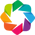

In [5]:
dpath = os.path.abspath(dpath)
hv.notebook_extension("bokeh", width=100)

## start cluster

In [6]:
cluster = LocalCluster(
    n_workers=n_workers,
    memory_limit="2GB",
    resources={"MEM": 1},
    threads_per_worker=2,
    dashboard_address=":8787",
)
annt_plugin = TaskAnnotation()
cluster.scheduler.add_plugin(annt_plugin)
client = Client(cluster)

# Pre-processing

## loading videos and visualization

In [7]:
print(colored("______ LOADING VIDEOS ... ______", "light_yellow"), file = open("CON", "w") )
param_load_videos

{'pattern': '^(1[3-8])\\.avi$',
 'dtype': numpy.uint8,
 'downsample': {'frame': 1, 'height': 1, 'width': 1},
 'downsample_strategy': 'subset'}

If you wish to downsample the video, pass in a dictionary to `downsample`, with the name of dimensions as keys and  the downsampling folds as integer value.
For example, `downsample=dict("frame"=2)` will temporally downsample the video with a factor of 2.
`downsample_strategy` will assume two values: either `"subset"`, meaning downsampling are carried out simply by subsetting the data, or `"mean"`, meaning a mean will be calculated on the window of downsampling (the latter being slower).

In [8]:
varr = load_videos(dpath, **param_load_videos)
chk, _ = get_optimal_chk(varr, dtype=float)
print(colored("______ VIDEOS LOADED ______", "yellow"), file = open("CON", "w") )

loading 6 videos in folder \\iss\karalis\users\nikolas.karalis\Data\FMI\Neuromod\nk50\nk50_s04_fc_fc\12_24_08\My_V4_Miniscope


In [9]:
#%%time
varr = save_minian(
    varr.chunk({"frame": chk["frame"], "height": -1, "width": -1}).rename("varr"),
    intpath,
    overwrite=True,
)

CPU times: total: 2.88 s
Wall time: 28.4 s


## glow removal and visualization

In [10]:
print(colored("______ PREPROCESSING ... ______", "light_yellow"), file = open("CON", "w") )
#%time
varr_ref = varr.sel(subset)
varr_min = varr_ref.min("frame").compute()
varr_ref = varr_ref - varr_min

CPU times: total: 578 ms
Wall time: 1.69 s


In [11]:
 varr_ref.min("frame")

<xarray.DataArray 'varr' (height: 608, width: 608)>
dask.array<amin-aggregate, shape=(608, 608), dtype=uint8, chunksize=(608, 608), chunktype=numpy.ndarray>
Coordinates:
  * height   (height) int32 0 1 2 3 4 5 6 7 ... 600 601 602 603 604 605 606 607
  * width    (width) int32 0 1 2 3 4 5 6 7 8 ... 600 601 602 603 604 605 606 607

In [12]:
hv.output(size=int(output_size * 0.7))
if interactive:
    vaviewer = VArrayViewer(
        [varr.rename("original"), varr_ref.rename("glow_removed")],
        framerate=30,
        summary=None,
        layout=True,
    )
    display(vaviewer.show())

Column
    [0] WidgetBox
        [0] Button(button_type='primary', height=30, name='Update Mask', sizing_mode='fixed', width=100)
        [1] Player(end=5999, height=90, interval=10, sizing_mode='fixed', width=650)
    [1] HoloViews(NdLayout)

## <font color='green'> STOP 2</font> <font color='red'> denoise</font>

In [13]:
param_denoise

{'method': 'median', 'ksize': 9}

<div class="alert alert-info">

Generally `ksize=5` is good (approximately half the diamater of the largest cell).
Note that if you do want to play with the ksize, it has to be odd number.
</div>

In [14]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(
        visualize_preprocess(
            varr_ref.isel(frame=0).compute(),
            denoise,
            method=["median"],
            ksize=[5, 7, 9,11,13],
        )
    )

:Layout
   .Image.Before        :Image   [width,height]   (varr)
   .DynamicMap.Before   :DynamicMap   []
      :RGB   [width,height]   (R,G,B,A)
   .DynamicMap.After.I  :DynamicMap   [method,ksize]
      :Image   [width,height]   (varr_denoised)
   .DynamicMap.After.II :DynamicMap   [method,ksize]
      :RGB   [width,height]   (R,G,B,A)

<div class="alert alert-info">

<font color='red'> Don't forget to update the parameter ksize</font>
</div>

In [15]:
param_denoise["ksize"] = 9
varr_ref = denoise(varr_ref, **param_denoise)

## <font color='green'> STOP 3 </font> <font color='red'>background removal </font>

In [16]:
param_background_removal

{'method': 'tophat', 'wnd': 15}

<div class="alert alert-info">

Pragmatically `wnd=15` works well.
</div>

In [17]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(
        visualize_preprocess(
            varr_ref.isel(frame=0).compute(),
            remove_background,
            method=["tophat"],
            wnd=[10, 15, 20],
        )
    )

:Layout
   .Image.Before        :Image   [width,height]   (varr_denoised)
   .DynamicMap.Before   :DynamicMap   []
      :RGB   [width,height]   (R,G,B,A)
   .DynamicMap.After.I  :DynamicMap   [method,wnd]
      :Image   [width,height]   (varr_denoised_subtracted)
   .DynamicMap.After.II :DynamicMap   [method,wnd]
      :RGB   [width,height]   (R,G,B,A)

<div class="alert alert-info">

<font color='red'>Don't forget to update the parameter wnd</font>
</div>

In [18]:
wnd = 15
param_background_removal["wnd"] = 15
varr_ref = remove_background(varr_ref, **param_background_removal)

## save result

Here we are saving our pre-processed video (`varr_ref`) into the intermediate folder (`intpath`).
Note that for every saved variable a separate folder will be created based on the `.name` attribute of that variable.
And variables with the same `.name` attribute will be saved to same folder regardless the variable name, potentially overwritting each other!
Here we [rename](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.rename.html) it to `"varr_ref"` so that the saved folder will be named "varr_ref.zarr".

In [19]:
#%%time
varr_ref = save_minian(varr_ref.rename("varr_ref"), dpath=intpath, overwrite=True)

CPU times: total: 1.95 s
Wall time: 30.9 s


# Motion Correction

## estimate motion

In [20]:
param_estimate_motion

{'dim': 'frame'}

In [21]:
#%%time
motion = estimate_motion(varr_ref.sel(subset_mc), **param_estimate_motion)

CPU times: total: 2.25 s
Wall time: 2.28 s


## save motion

In [22]:
param_save_minian

{'dpath': 'C:/Users/axelle.piguet/Documents/GitHub/klab_analysis/Axelle\\nk50/nk50_s04_fc_fc/12_24_08/My_V4_Miniscope\\result',
 'meta_dict': {'session': -1, 'animal': -2},
 'overwrite': True}

As mentioned before `param_save_minian` decides how your data will be saved and what metadata will be stored.
Additionally we use the `chk` variable earlier to make sure all our data have same chunk size along same dimension.

In [23]:
#%%time
motion = save_minian(
    motion.rename("motion").chunk({"frame": chk["frame"]}), **param_save_minian
)

CPU times: total: 9.72 s
Wall time: 3min 53s


## apply transform

In [24]:
Y = apply_transform(varr_ref, motion, fill=0)
print(colored("______ PREPROCESSING DONE ______", "yellow"), file = open("CON", "w") )

## save result

Here we save two versions of the motion-corrected movie `Y`.
Their contents are identical.
The only difference is how they are chunked.
Also note that we convert the data to `float` type for better downstream processing.

In [25]:
#%%time
Y_fm_chk = save_minian(Y.astype(float).rename("Y_fm_chk"), intpath, overwrite=True)
Y_hw_chk = save_minian(
    Y_fm_chk.rename("Y_hw_chk"),
    intpath,
    overwrite=True,
    chunks={"frame": -1, "height": chk["height"], "width": chk["width"]},
)

OSError: [Errno 28] No space left on device

## generate video for motion-correction

In [26]:
#%%time
vid_arr = xr.concat([varr_ref, Y_fm_chk], "width").chunk({"width": -1})
write_video(vid_arr, "minian_mc.mp4",param_save_minian['dpath']) #dpath)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


NameError: name 'Y_fm_chk' is not defined

In [27]:
print(colored("______ RESULTS SAVED ______", "light_green"), file = open("CON", "w") )

'\\\\iss\\karalis\\users\\nikolas.karalis\\Data\\FMI\\Neuromod\\nk50\\nk50_s04_fc_fc\\12_24_08\\My_V4_Miniscope'

# Initialization

## compute max projection

In [28]:
print(colored("______ IDENTIFYING CELLS ______", "light_yellow"), file = open("CON", "w") )
max_proj = save_minian(
    Y_fm_chk.max("frame").rename("max_proj"), **param_save_minian
).compute()

NameError: name 'Y_fm_chk' is not defined

## generating over-complete set of seeds

In [ ]:
param_seeds_init

The idea is that we select some subset of frames, compute a max projection of those frames, and find the local maxima of that max projection.
We keep repeating this process and we collect all the local maxima until we obtain an overly-complete set of local maximas, which are the potential locations of cells, which we call **seeds**.
The assumption here is that the center of cells are brighter than their surroundings on some, but not necessarily all, frames.
There are several parameters controlling how we subset the frames:
By default we use `method="rolling"`, which use a rolling window across time to chunk and compute max projections.
`wnd_size` controls the number of frames in each chunk.
`stp_size` is the distance between the center of each chunk.
For example, if `wnd_size=100` and `stp_size=50`, the windows will be as follows: (0, 100), (50, 150), (100, 200)...
Alternatively you can use `method="random"` to use random sampling of frames instead of rolling window.
See the [API reference](https://minian.readthedocs.io/page/api/minian.initialization.html#minian-initialization-seeds_init) of `seeds_init` for details.
Additionally we have two parameters controlling how the local maxima are found.
`max_wnd` controls the window size within which a single pixel will be choosen as local maxima.
In order to capture cells with all sizes, we actually find local maximas with different window size and merge all of them, starting from 2 all the way up to `max_wnd`.
Hence `max_wnd` should be the radius of the **largest** cell you want to detect.
Finally in order to get rid of local maxima with very little fluctuation, we set a `diff_thres` which is the minimal fluorescent diffrence of a seed across `frame`s.
Since the linear scale of the raw data is preserved, we can set this threshold empirically.

In [ ]:
#%%time
seeds = seeds_init(Y_fm_chk, **param_seeds_init)

The `seeds` variable is a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), with each row representing a seed.
The column "height" and "width" defines the location of the seed.
The column "seeds" is the number of chunks where the particular seed/pixel is considered a local maxima.

## <font color='green'> STOP 4 </font> <font color='red'>peak-noise-ratio refine</font>

In [ ]:
#%%time
if interactive:
    noise_freq_list = [0.005, 0.01, 0.02, 0.06, 0.1, 0.2, 0.3, 0.45, 0.6, 0.8]
    example_seeds = seeds.sample(6, axis="rows")
    example_trace = Y_hw_chk.sel(
        height=example_seeds["height"].to_xarray(),
        width=example_seeds["width"].to_xarray(),
    ).rename(**{"index": "seed"})
    smooth_dict = dict()
    for freq in noise_freq_list:
        trace_smth_low = smooth_sig(example_trace, freq)
        trace_smth_high = smooth_sig(example_trace, freq, btype="high")
        trace_smth_low = trace_smth_low.compute()
        trace_smth_high = trace_smth_high.compute()
        hv_trace = hv.HoloMap(
            {
                "signal": (
                    hv.Dataset(trace_smth_low)
                    .to(hv.Curve, kdims=["frame"])
                    .opts(frame_width=300, aspect=2, ylabel="Signal (A.U.)")
                ),
                "noise": (
                    hv.Dataset(trace_smth_high)
                    .to(hv.Curve, kdims=["frame"])
                    .opts(frame_width=300, aspect=2, ylabel="Signal (A.U.)")
                ),
            },
            kdims="trace",
        ).collate()
        smooth_dict[freq] = hv_trace


At the end of the process, we put together a `smooth_dict`.
Here we convert that into an interactive plot, from which we can determine the frequency that best separates noise and signal.

In [ ]:
hv.output(size=int(output_size * 0.7))
if interactive:
    hv_res = (
        hv.HoloMap(smooth_dict, kdims=["noise_freq"])
        .collate()
        .opts(aspect=2)
        .overlay("trace")
        .layout("seed")
        .cols(3)
    )
    display(hv_res)

<div class="alert alert-info">
<strong>picking noise frequency</strong>

We can now use the interactive visualization to pick the best cut-off frequency.
Here is an example of what you might see:

<div stype="clear:both"><img src="img/param_pnr.png" style="width: 50%"/></div>

We are looking for the frequency that can best seperate real signal from noise.
Hence, `noise_freq=0.005` in the example is not ideal, since real calcium activities are overly smoothed as well.
At the same time, `noise_freq=0.45` is not ideal either, since a lot of high-frequency noise are visible in the signal.
Hence, `noise_freq=0.05` in the middle is a good choice in this example.
Now, say you already found your parameters, it's time now to pass them in! Either go back to initial parameters setting step and modify them there, or call the parameter here and change its value/s accordingly.
</div>

<div class="alert alert-info">

<font color='red'>Don't forget to update the parameters</font>
</div>

In [ ]:
noise_freq = 0.1
param_pnr_refine["noise_freq"] =noise_freq
param_pnr_refine

## <font color='green'> STOP 5 </font> <font color='red'>seed threshold</font>

First we filter the temporal activities for each seed using the `noise_freq` we choose.
**signal** is defined as the low-pass filtered temporal signal, while **noise** is high-pass filtered signal.
Then we compute the peak-to-peak value (max minus min) for both the **real** signal and **noise** signal.
The peak-noise-ratio is defined as the ratio between the peak-to-peak value of **signal** and that of **noise**.
We then threshold the seeds based on this peak-noise-ratio, with the assumption that temporal activities from real cells should have higher fluctuation in the low-frequency range and lower fluctuation in the high-frequency range.
`thres` is the threshold for peak-noise-ratios.
Pragmatically `thres=1` works fine and makes sense.
You can also use `thres="auto"`, where a gaussian mixture model with 2 components will be run on the peak-noise-ratios and seeds will be selected if they belong to the "higher" gaussian.

In [ ]:
#%%time
seeds, pnr, gmm = pnr_refine(Y_hw_chk, seeds, **param_pnr_refine)

<div class="alert alert-info">

If you see seeds being filtered out that you believe should be cells, either skip this step or try lower the threshold a bit.
</div>

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds, "mask_pnr")

<div class="alert alert-info">

<font color='red'>Don't forget to update the parameters</font>
</div>

In [ ]:
thres = 0.5
param_pnr_refine["thres"] =thres
param_pnr_refine

## ks refine

In [ ]:
param_ks_refine

In [ ]:
#%%time
seeds = ks_refine(Y_hw_chk, seeds, **param_ks_refine)

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds, "mask_ks")

## <font color='green'> STOP 6 </font> <font color='red'>merge seeds</font>

In [ ]:
param_seeds_merge['thres_dist'] = 6
param_seeds_merge

<div class="alert alert-info">

<font color='red'>Don't forget to update the parameter thres_dist</font>
</div>

In [ ]:
#%%time
seeds_final = seeds[seeds["mask_ks"] & seeds["mask_pnr"]].reset_index(drop=True)
seeds_final = seeds_merge(Y_hw_chk, max_proj, seeds_final, **param_seeds_merge)

We visualize the result on top of the max projection.
The red dots here indicate seeds that has been merged to nearby seeds (those shown in white).

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds_final, "mask_mrg")
print(colored("______ CELLS FOUND ______", "yellow"), file = open("CON", "w") )

## initialize spatial matrix

In [ ]:
print(colored("______ COMPUTING TRACES ______", "light_yellow"), file = open("CON", "w") )
param_initialize['wnd'] = wnd
param_initialize['noise_freq'] = noise_freq
param_initialize

In [ ]:
#%%time
A_init = initA(Y_hw_chk, seeds_final[seeds_final["mask_mrg"]], **param_initialize)
A_init = save_minian(A_init.rename("A_init"), intpath, overwrite=True)

## initialize temporal matrix

In [ ]:
#%%time
C_init = initC(Y_fm_chk, A_init)
C_init = save_minian(
    C_init.rename("C_init"), intpath, overwrite=True, chunks={"unit_id": 1, "frame": -1}
)

## merge units

In [ ]:


param_init_merge

In [ ]:
#%%time
A, C = unit_merge(A_init, C_init, **param_init_merge)
A = save_minian(A.rename("A"), intpath, overwrite=True)
C = save_minian(C.rename("C"), intpath, overwrite=True)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)

## initialize background terms

Finally, we need two more terms: `b` and `f`, representing the spatial footprint and temporal dynamics of the background, respectively.
We first compute an estimation of cellular activities by taking the outer product of `A` and `C`, resulting in an video array with dimesion `height`, `width` and `frame`.
We then subtract this array from `Y_fm_chk`, resulting in a "residule" movie.
Then `b` is estimated as the mean projection of the "residule" movie, while `f` is estimated as the fluorescence fluctuation of `b` that best fit the "residule" movie (least-square solution).

In [ ]:
%%time
b, f = update_background(Y_fm_chk, A, C_chk)
f = save_minian(f.rename("f"), intpath, overwrite=True)
b = save_minian(b.rename("b"), intpath, overwrite=True)

## visualization of initialization

Finally we visualize the result of our initialization by plotting a projection of the spatial matrix `A`, a raster of the temporal matrix `C`, as well as background terms `b` and `f`.

In [ ]:
hv.output(size=int(output_size * 0.55))
im_opts = dict(
    frame_width=500,
    aspect=A.sizes["width"] / A.sizes["height"],
    cmap="Viridis",
    colorbar=True,
)
cr_opts = dict(frame_width=750, aspect=1.5 * A.sizes["width"] / A.sizes["height"])
(
    regrid(
        hv.Image(
            A.max("unit_id").rename("A").compute().astype(np.float32),
            kdims=["width", "height"],
        ).opts(**im_opts)
    ).relabel("Initial Spatial Footprints")
    + regrid(
        hv.Image(
            C.rename("C").compute().astype(np.float32), kdims=["frame", "unit_id"]
        ).opts(cmap="viridis", colorbar=True, **cr_opts)
    ).relabel("Initial Temporal Components")
    + regrid(
        hv.Image(
            b.rename("b").compute().astype(np.float32), kdims=["width", "height"]
        ).opts(**im_opts)
    ).relabel("Initial Background Sptial")
    + datashade(hv.Curve(f.rename("f").compute(), kdims=["frame"]), min_alpha=200)
    .opts(**cr_opts)
    .relabel("Initial Background Temporal")
).cols(2)

# CNMF

This section assumes you already have some background knowledge about the CNMF algorithm.
Please refer to the [the paper](https://www.sciencedirect.com/science/article/pii/S0896627315010843) for detailed information of the algorithm. 

As a quick recap, here is the essential idea of CNMF:
We believe our movie, `Y`, with dimensions `height`, `width` and `frame`, can be written in (and thus broken down as) the following equation:

$$\mathbf{Y} = \mathbf{A}^T \mathbf{C} + \mathbf{b}^T \mathbf{f} + \epsilon$$

where:

* `A` is the spatial footprint of each unit, with dimension `height`, `width` and `unit_id`.
* `C` is the temporal activities of each unit, with dimension `unit_id` and `frame`.
* `b` and `f` are the spatial footprint and temporal activities of some background, respectively.
* $\epsilon$ is the noise.

Note that strictly speaking, matrix multiplication is usually only defined for two dimensional matrices, but our `A` here has three dimensions, so in fact we are taking the [tensor product](https://en.wikipedia.org/wiki/Tensor_product) of `A` and `C`, reducing the dimension `unit_id`.
This might seem to complicate things (compared to just treating `height` and `width` as one flattened `spatial` dimension), but it ends up making some sense.
When you take a dot product of any two "matrices" on a certain **dimension**, all that is happening is a **product** followed by a **sum** -- you take the product for all pairs of numbers with the the same indexes from the two "matrices", and then you take the sum of all those products along the dimension.
Thus when we take the tensor product of `A` and `C`, we are actually multiplying all those numbers in dimension `height`, `width` and `frame`, matched by `unit_id`, and then take the sum.
Conceptually, for each unit, we are weighting the spatial footprint (`height` and `width`) by the fluorecense of that unit on given `frame`, which is the **product**, and then we are collapsing all units together, which is the **sum**.
With that, the equation above is trying to say that our movie is made up of a weighted sum of the spatial footprint and temporal activities of all units, plus some background and noise.

Now, there is another rule about `C` that separates it from background and noise:
Each "row" of `C`, which is the temporal trace for each unit, should be described as an [autoregressive process](https://en.wikipedia.org/wiki/Autoregressive_model) (AR process), with a parameter `p` defining the **order** of the AR process:

$$ c(t) = \sum_{i=0}^{p}\gamma_i c(t-i) + s(t) + \epsilon$$

where:

* $c(t)$ is the calcium concentration at time (`frame`) $t$.
* $s(t)$ is spike/firing rate at time $t$.
* $\epsilon$ is noise.

Basically, this equation is trying to say that at any given time $t$, the calcium concentration at that moment $c(t)$ depends on the spike at that moment $s(t)$, as well as its own history up to `p` time-steps back $c(t-i)$, scaled by some parameters $\gamma_i$s, plus some noise $\epsilon$.
Another intuition of this equation comes from looking at different `p`s: when `p=0`, the calcium concentration is an exact copy of the spiking activities, which is probably not true.
When `p=1`, the calcium concentration has an instant rise in response to a spike followed by an exponential decay.
When `p=2`, calcium concentration has some rise time following a spike and an exponential decay.

With all this in mind, CNMF tries to find the spatial matrix (`A`) and temporal activity (`C`) (along with `b` and `f`) that best describe `Y`.
There are a few more important practical concerns: Firstly we cannot solve this problem in one shot -- we need to iteratively and separately update `A` and `C` to approach the true solution.
Often enough,  two iterations  after the initialization seem to give good enough results, but you can always add more iterations.
Secondly, by intuition you may define "best describe `Y`" as the results that minimize the noise/error $\epsilon$.
However we have to control for the [sparsity](https://en.wikipedia.org/wiki/Sparse_matrix) of our model as well, since we do not want every little random pixel that happens to correlate with a cell to be counted as part of the spatial footprint of the cell (non-sparse `A`), nor do we want a tiny spike at every frame trying to explain every noisy peak we observe (non-sparse `C`).
Thus, the balance between fidelity (minimizing error) and sparsity (minimizing non-zero entries) is an important concern for both the spatial and temporal update.

## estimate spatial noise

In [ ]:
param_get_noise

<div class="alert alert-info">

It is recommended to use the cut-off frequency you find during [peak-noise-ratio refine](#peak-noise-ratio-refine) as the lower bound of `noise_range` to be consistent.
</div>

In [ ]:
#%%time
sn_spatial = get_noise_fft(Y_hw_chk, **param_get_noise)
sn_spatial = save_minian(sn_spatial.rename("sn_spatial"), intpath, overwrite=True)

## <font color='green'> STOP 7 </font> <font color='red'>first spatial update</font>

### parameter exploration

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C.sel(unit_id=units).persist()

In [ ]:
#%%time
if interactive:
    sprs_ls = [0.005, 0.01, 0.05]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_mask, cur_norm = update_spatial(
            Y_hw_chk,
            A_sub,
            C_sub,
            sn_spatial,
            in_memory=True,
            dl_wnd=param_first_spatial["dl_wnd"],
            sparse_penal=cur_sprs,
        )
        if cur_A.sizes["unit_id"]:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = C_sub.sel(unit_id=cur_mask).compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=["sparse penalty"])

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

<div class="alert alert-info">
<strong>choosing sparse penalty for spatial update</strong>

Here is an example of what you might see during the parameter exploration:
    
<div stype="clear:both"><img src="img/param_spatial_update.png" style="width: 70%"/></div>

As you can see the `sparse_penal` parameter directly controls the overal sparsity of the resulting spatial footprints.
When `sparse_penal=0.01`, the spatial footprints extend far away from the centorids of cells, resulting in high overlap between cells and unnatrual shapes.
This is more evident from the binary spatial footprints.
At the same time, when `sparse_penal=1`, the algorithm become too strict, and only one cell is left as acceptable.
This is also not desirable and we usually want to avoid dropping cells during spatial update.
Hence in this example, `sparse_penal=0.3` is considered a good choice among the three cases.

</div>

### spatial update

<div class="alert alert-info">
</font> <font color='red'>Don't forget to update the sparse penalty parameter</font>
</div>

In [ ]:
param_first_spatial['sparse_penal'] = 0.01
param_first_spatial

When carrying out spatial update, it is very inefficient to estimate a weight for all the cells for each pixel.
Instead, when updating for each pixel, we only want to consider cells that are close by and ignore cells that are very far from the pixel being updated.
For this purpose we carry out a [morphological dilation](https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm) on the spatial footprints of each cell using the previous estimation of `A`.
We then binarize this dilated spatial footprints matrix and use it as a mask.
Then when updating for each pixel, only cells that have non-zero values in the mask on this pixel will be considered for update.
The parameter `dl_wnd` controls the window size of the morphological dilation operation.

The scalar `sparse_penal` controls the balance between error objective and the l1-norm term.
The higher the `sparse_penal`, the sparser the result will become.
It is hard to estimate theoretically, and the best way to set this is through parameter exploration.

Lastly, it is often convenient to filter out cells that has either too large or too small spatial footprints at this step.
The `size_thres` controls the range of area (number of non-zero pixels) of the spatial footprints that will be accepted.

In [ ]:
#%%time
A_new, mask, norm_fac = update_spatial(
    Y_hw_chk, A, C, sn_spatial, **param_first_spatial
)
C_new = save_minian(
    (C.sel(unit_id=mask) * norm_fac).rename("C_new"), intpath, overwrite=True
)
C_chk_new = save_minian(
    (C_chk.sel(unit_id=mask) * norm_fac).rename("C_chk_new"), intpath, overwrite=True
)

After obtaining a better estimation of spatial footprints, we update the background terms.

In [ ]:
#%%time
b_new, f_new = update_background(Y_fm_chk, A_new, C_chk_new)

### visualization of spatial footprints

In [ ]:
hv.output(size=int(output_size * 0.6))
opts = dict(
    plot=dict(height=A.sizes["height"], width=A.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
(
    regrid(
        hv.Image(
            A.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints Initial")
    + regrid(
        hv.Image(
            (A.fillna(0) > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints Initial")
    + regrid(
        hv.Image(
            A_new.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints First Update")
    + regrid(
        hv.Image(
            (A_new > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints First Update")
).cols(2)

### save results

In [ ]:
#%%time
A = save_minian(
    A_new.rename("A"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "height": -1, "width": -1},
)
b = save_minian(b_new.rename("b"), intpath, overwrite=True)
f = save_minian(
    f_new.chunk({"frame": chk["frame"]}).rename("f"), intpath, overwrite=True
)
C = save_minian(C_new.rename("C"), intpath, overwrite=True)
C_chk = save_minian(C_chk_new.rename("C_chk"), intpath, overwrite=True)

## <font color='green'> STOP 8 </font> <font color='red'>first temporal update</font> 

### parameter exploration

First off we randomly select 10 cells to do parameter exploring.

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C_chk.sel(unit_id=units).persist()

In [ ]:
#%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.1, 0.5, 1, 2]
    add_ls = [20]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    YrA = (
        compute_trace(Y_fm_chk, A_sub, b, C_sub, f)
        .persist()
        .chunk({"unit_id": 1, "frame": -1})
    )
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(
        p_ls, sprs_ls, add_ls, noise_ls
    ):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print(
            "p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}".format(
                cur_p, cur_sprs, cur_add, cur_noise
            )
        )
        cur_C, cur_S, cur_b0, cur_c0, cur_g, cur_mask = update_temporal(
            A_sub,
            C_sub,
            YrA=YrA,
            sparse_penal=cur_sprs,
            p=cur_p,
            use_smooth=True,
            add_lag=cur_add,
            noise_freq=cur_noise,
        )
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA.compute(),
            cur_C.compute(),
            cur_S.compute(),
            cur_g.compute(),
            (cur_C + cur_b0 + cur_c0).compute(),
            A_sub.compute(),
        )
    hv_res = visualize_temporal_update(
        YA_dict,
        C_dict,
        S_dict,
        g_dict,
        sig_dict,
        A_dict,
        kdims=["p", "sparse penalty", "additional lag", "noise frequency"],
    )

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

<div class="alert alert-info">
<strong>choosing sparse penalty for temporal update</strong>

Here is an example of what you might see during the parameter exploration:
    
<div stype="clear:both"><img src="img/param_temporal_update.png" style="width: 50%"/></div>

As you can see the `sparse_penal` parameter directly controls the overal sparsity of the resulting calcium dynamic and deconvolved spikes.
When `sparse_penal=1`, the fitted spikes contains lots of small valued fluctuations, that mostly correspond to high-frequency noise instead of real calcium dynamic.
At the same time, when `sparse_penal=10`, the sparse penalty is too large, and a lot of real calcium dynamics, as evident in the raw signal, are left out in the fitted calcium and spike traces.
Hence in this example, `sparse_penal=3` is considered a good choice among the three cases.

</div>

<div class="alert alert-info">
</font> <font color='red'>Don't forget to update the sparse penalty parameter</font>
</div>

In [ ]:
param_first_temporal['sparse_penal'] = 0.5

### temporal update

In [ ]:
#%%time
YrA = save_minian(
    compute_trace(Y_fm_chk, A, b, C_chk, f).rename("YrA"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "frame": -1},
)

In [ ]:
param_first_temporal

Although we obtained `YrA` for each unit, it is still beneficial to group together units that heavily overlap, and carry out the update process group-wise instead of independently for each unit.
This way the relative numerical relationship between heavily-overlapping units are better preserved.
For this purpose, we compute pairwise [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) for all units, which serve as a metric of overlap between spatial footprints of units.
The parameter `jac_thres` is the threshold of Jaccard index above which units will be grouped together transitively.

<div class="alert alert-info">

Since the grouping of units is transitive and uses binarized spatial footprints, in practive you may find large amount of units being grouped together if the spatial footprints is not sparse enough.
This lead to significantly increased memory demand, and potential "masking" effect between units (activities of highly active units suppress the activities of less active units when grouped together).
If this happens, consider either refine the spatial footprints or increase the `jac_thres`.
</div>

Regarding the actual optimization process, the first thing we want to determine is order of the AR process `p`.
Usually, `p=1` is good enough and tend to result in multiple spikes in the deconvolved signal `S` accounting for a single rise of calcium concentration in `C`.
However, if you believe the rise time of your calcium signal is not neglectable, and a single rise of calcium concentration should be modeled as a single calcium event in the deconvolved signal `S`, then `p=2` is a better choice since it allows for modeling of non-zero rise time.

Next, we estimate the AR coefficients from the auto-covariance of the `YrA` signal for each cell.
Two additional steps can improve the reliability of this estimation.
First, the `YrA` can be smoothed for estimation of the AR coefficients.
This can help prevent the high frequency noise in `YrA` biasing the estimation of AR proces in to very fast dynamics.
The `noise_freq` parameter is the cut-off frequency of this low-pass filtering.
Secondly, although in theory only `p` auto-covariances are needed to solve `p` number of AR coefficients, we can use auto-covariance more than `p` time lags and solve for AR coefficients using least square.
This help make the estimation numerically more stable.
The `add_lag` parameter is the number of additional auto-covariance to use for estimating AR coefficients.

<div class="alert alert-info">

The `noise_freq` should be set to those determined in [peak-noise-ratio refine](#peak-noise-ratio-refine) to be consistent.
The `add_lag` usually have limited impact on the result as long as it is large enough.
Pragmatically we have found `add_lag=20` works for most cases.
However calcium dynamic are very slow in your data, you might have to increase `add_lag` so that auto-covariance with further time lag may contribute to the estimation of AR coefficients.
</div>

Finally, the scalar `sparse_penal` controls the balance between the error and l1-norm of `C` in the optimization objective.
The higher the value, the sparser both `C` and `S` will become.
It is hard to estimate theoretically, and the best way to set this is through parameter exploration.
Note that despite the name, this is a completely different parameter than the one in spatial updates.

In [ ]:
#%%time
C_new, S_new, b0_new, c0_new, g, mask = update_temporal(
    A, C, YrA=YrA, **param_first_temporal
)

### visualization of dropped units

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    h, w = A.sizes["height"], A.sizes["width"]
    im_opts = dict(aspect=w / h, frame_width=500, cmap="Viridis")
    cr_opts = dict(aspect=3, frame_width=1000)
    bad_units = mask.where(mask == False, drop=True).coords["unit_id"].values
    if len(bad_units) > 0:
        hv_res = (
            hv.NdLayout(
                {
                    "Spatial Footprint": Dynamic(
                        hv.Dataset(A.sel(unit_id=bad_units).compute().rename("A"))
                        .to(hv.Image, kdims=["width", "height"])
                        .opts(**im_opts)
                    ),
                    "Spatial Footprints of Accepted Units": Dynamic(
                        hv.Image(
                            A.sel(unit_id=mask).sum("unit_id").compute().rename("A"),
                            kdims=["width", "height"],
                        ).opts(**im_opts)
                    ),
                }
            )
            + datashade(
                hv.Dataset(YrA.sel(unit_id=bad_units).rename("raw")).to(
                    hv.Curve, kdims=["frame"]
                )
            )
            .opts(**cr_opts)
            .relabel("Temporal Trace")
        ).cols(1)
        display(hv_res)
    else:
        print("No rejected units to display")

### visualization of accepted units

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    sig = C_new + b0_new + c0_new
    display(
        visualize_temporal_update(
            YrA.sel(unit_id=mask),
            C_new,
            S_new,
            g,
            sig,
            A.sel(unit_id=mask),
        )
    )



### save results

In [ ]:
#%%time
C = save_minian(
    C_new.rename("C").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
S = save_minian(
    S_new.rename("S").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
b0 = save_minian(
    b0_new.rename("b0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
c0 = save_minian(
    c0_new.rename("c0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
A = A.sel(unit_id=C.coords["unit_id"].values)

## merge units

In [ ]:
param_first_merge

The idea is straight-forward and based purely on correlation of temporal activities.
Any units whose spatial footprints share at least one pixel are considered potential targets for merging, and any of these units that have a correlation of temporal activities higher than `thres_corr` will be merged. 

In [ ]:
#%%time
A_mrg, C_mrg, [sig_mrg] = unit_merge(A, C, [C + b0 + c0], **param_first_merge)

In [ ]:
hv.output(size=int(output_size * 0.6))
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap="Viridis")
(
    regrid(
        hv.Image(
            C.compute().astype(np.float32).rename("c1"), kdims=["frame", "unit_id"]
        )
        .relabel("Temporal Signals Before Merge")
        .opts(**opts_im)
    )
    + regrid(
        hv.Image(
            C_mrg.compute().astype(np.float32).rename("c2"), kdims=["frame", "unit_id"]
        )
        .relabel("Temporal Signals After Merge")
        .opts(**opts_im)
    )
)

Once we are satisfied with the result of merging we can commit to saving them to intermediate folder.

In [ ]:
%%time
A = save_minian(A_mrg.rename("A_mrg"), intpath, overwrite=True)
C = save_minian(C_mrg.rename("C_mrg"), intpath, overwrite=True)
C_chk = save_minian(
    C.rename("C_mrg_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
sig = save_minian(sig_mrg.rename("sig_mrg"), intpath, overwrite=True)

## <font color='green'> STOP 9</font> <font color='red'>second spatial update</font> 

This section analogous to the [first time](#first-spatial-update) we so spatial update except for changes in variable names.

### parameter exploration

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = sig.sel(unit_id=units).persist()

In [ ]:
#%%time
if interactive:
    sprs_ls = [5e-3, 1e-2, 5e-2]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_mask, cur_norm = update_spatial(
            Y_hw_chk,
            A_sub,
            C_sub,
            sn_spatial,
            in_memory=True,
            dl_wnd=param_second_spatial["dl_wnd"],
            sparse_penal=cur_sprs,
        )
        if cur_A.sizes["unit_id"]:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = C_sub.sel(unit_id=cur_mask).compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=["sparse penalty"])

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

### spatial update

<div class="alert alert-info">
</font> <font color='red'>Don't forget to update the sparse penalty parameter</font>
</div>

In [ ]:
param_second_spatial['sparse_penal'] = 0.01
param_second_spatial

In [ ]:
#%%time
A_new, mask, norm_fac = update_spatial(
    Y_hw_chk, A, C, sn_spatial, **param_second_spatial
)
C_new = save_minian(
    (C.sel(unit_id=mask) * norm_fac).rename("C_new"), intpath, overwrite=True
)
C_chk_new = save_minian(
    (C_chk.sel(unit_id=mask) * norm_fac).rename("C_chk_new"), intpath, overwrite=True
)

In [ ]:
#%%time
b_new, f_new = update_background(Y_fm_chk, A_new, C_chk_new)

### visualization of spatial footprints

In [ ]:
hv.output(size=int(output_size * 0.6))
opts = dict(
    plot=dict(height=A.sizes["height"], width=A.sizes["width"], colorbar=True),
    style=dict(cmap="Viridis"),
)
(
    regrid(
        hv.Image(
            A.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints Last")
    + regrid(
        hv.Image(
            (A.fillna(0) > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints Last")
    + regrid(
        hv.Image(
            A_new.max("unit_id").compute().astype(np.float32).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Spatial Footprints New")
    + regrid(
        hv.Image(
            (A_new > 0).sum("unit_id").compute().astype(np.uint8).rename("A"),
            kdims=["width", "height"],
        ).opts(**opts)
    ).relabel("Binary Spatial Footprints New")
).cols(2)

### save results

In [ ]:
#%%time
A = save_minian(
    A_new.rename("A"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "height": -1, "width": -1},
)
b = save_minian(b_new.rename("b"), intpath, overwrite=True)
f = save_minian(
    f_new.chunk({"frame": chk["frame"]}).rename("f"), intpath, overwrite=True
)
C = save_minian(C_new.rename("C"), intpath, overwrite=True)
C_chk = save_minian(C_chk_new.rename("C_chk"), intpath, overwrite=True)

## <font color='green'> STOP 10</font> <font color='red'>second temporal update</font> 

### parameter exploration

In [ ]:
if interactive:
    units = np.random.choice(A.coords["unit_id"], 10, replace=False)
    units.sort()
    A_sub = A.sel(unit_id=units).persist()
    C_sub = C_chk.sel(unit_id=units).persist()

In [ ]:
#%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.1, 0.5, 1, 2]
    add_ls = [20]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    YrA = (
        compute_trace(Y_fm_chk, A_sub, b, C_sub, f)
        .persist()
        .chunk({"unit_id": 1, "frame": -1})
    )
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(
        p_ls, sprs_ls, add_ls, noise_ls
    ):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print(
            "p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}".format(
                cur_p, cur_sprs, cur_add, cur_noise
            )
        )
        cur_C, cur_S, cur_b0, cur_c0, cur_g, cur_mask = update_temporal(
            A_sub,
            C_sub,
            YrA=YrA,
            sparse_penal=cur_sprs,
            p=cur_p,
            use_smooth=True,
            add_lag=cur_add,
            noise_freq=cur_noise,
        )
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA.compute(),
            cur_C.compute(),
            cur_S.compute(),
            cur_g.compute(),
            (cur_C + cur_b0 + cur_c0).compute(),
            A_sub.compute(),
        )
    hv_res = visualize_temporal_update(
        YA_dict,
        C_dict,
        S_dict,
        g_dict,
        sig_dict,
        A_dict,
        kdims=["p", "sparse penalty", "additional lag", "noise frequency"],
    )

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    display(hv_res)

### temporal update

<div class="alert alert-info">
</font> <font color='red'>Don't forget to update the sparse penalty parameter</font>
</div>

In [ ]:
param_second_temporal['sparse_penal'] = 0.5
param_second_temporal

In [ ]:
#%%time
YrA = save_minian(
    compute_trace(Y_fm_chk, A, b, C_chk, f).rename("YrA"),
    intpath,
    overwrite=True,
    chunks={"unit_id": 1, "frame": -1},
)

In [ ]:
#%%time
C_new, S_new, b0_new, c0_new, g, mask = update_temporal(
    A, C, YrA=YrA, **param_second_temporal
)

In [ ]:
hv.output(size=int(output_size * 0.6))

### visualization of accepted units

In [ ]:
hv.output(size=int(output_size * 0.6))
if interactive:
    sig = C_new + b0_new + c0_new
    display(
        visualize_temporal_update(
            YrA.sel(unit_id=mask),
            C_new,
            S_new,
            g,
            sig,
            A.sel(unit_id=mask),
        )
    )
print(colored("______ COMPUTATIONS DONE ______", "yellow"), file = open("CON", "w") )

### save results

In [ ]:
#%%time
C = save_minian(
    C_new.rename("C").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
C_chk = save_minian(
    C.rename("C_chk"),
    intpath,
    overwrite=True,
    chunks={"unit_id": -1, "frame": chk["frame"]},
)
S = save_minian(
    S_new.rename("S").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
b0 = save_minian(
    b0_new.rename("b0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
c0 = save_minian(
    c0_new.rename("c0").chunk({"unit_id": 1, "frame": -1}), intpath, overwrite=True
)
A = A.sel(unit_id=C.coords["unit_id"].values)

## playing around

In [ ]:
for idx in A_init["unit_id"].values:
    print('unit number is %d with height %d and width %d'% (idx,np.argmax(np.sum(A_init.sel(unit_id  =idx).values,1)),np.argmax(np.sum(A_init.sel(unit_id  = idx).values,0))))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 15)) 
for idx in C["unit_id"].values:
    color = 'palevioletred'
    if idx % 2 : 
        color = 'purple'
    plt.plot(C.sel( unit_id = idx) + 10*idx, color)
plt.xlabel('Time')
plt.ylabel('Units')
plt.gca().spines['top'].set_visible(False)  # Hides the top spine
plt.gca().spines['right'].set_visible(False)  # Hides the right spine
plt.gca().xaxis.set_ticks([])
plt.gca().set_xticklabels([]) 

In [ ]:
fig, ax = plt.subplots()
fig.figsize=(7, 15)
im = ax.imshow(S, aspect = 'auto', cmap = 'binary')
plt.xlabel('Time')
plt.ylabel('Units')
plt.gca().spines['top'].set_visible(False)  # Hides the top spine
plt.gca().spines['right'].set_visible(False)  # Hides the right spine
plt.gca().xaxis.set_ticks([])
plt.gca().set_xticklabels([])

In [ ]:
order = np.argsort(np.argmax(C.values,1))
fig, ax = plt.subplots()
fig.figsize=(7, 15)
im = ax.imshow(S.values[order], aspect = 'auto', cmap = 'binary')
plt.xlabel('Time')
plt.ylabel('Units')
plt.gca().spines['top'].set_visible(False)  # Hides the top spine
plt.gca().spines['right'].set_visible(False)  # Hides the right spine
plt.gca().xaxis.set_ticks([])
plt.gca().set_xticklabels([])

In [ ]:
plt.figure(figsize=(7, 15)) 
i = 0 

for idx in C.unit_id.values[order]:
    i = i+1
    color = 'teal'
    if i % 2 : 
        color = 'darkseagreen'
    plt.plot(C.sel( unit_id = idx) - 10*i, color)
plt.xlabel('Time')
plt.ylabel('Units')
plt.gca().spines['top'].set_visible(False)  # Hides the top spine
plt.gca().spines['right'].set_visible(False)  # Hides the right spine
plt.gca().xaxis.set_ticks([])
plt.gca().set_xticklabels([])

## visualization

In [ ]:
#%%time
generate_videos(varr.sel(subset), Y_fm_chk, A=A, C=C_chk, vpath=param_save_minian['dpath'])#dpath)

In [ ]:
#%%time
if interactive:
    cnmfviewer = CNMFViewer(A=A, C=C, S=S, org=Y_fm_chk)

In [ ]:
hv.output(size=int(output_size * 0.35))
if interactive:
    display(cnmfviewer.show())

## save unit labels

If manual manipulation of `unit_labels` are done during visualization, we should assign them as coordinates to our final results.

In [ ]:
if interactive:
    A = A.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    C = C.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    S = S.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    c0 = c0.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))
    b0 = b0.assign_coords(unit_labels=("unit_id", cnmfviewer.unit_labels))

## save final results

Finally we commit to saving final results using `param_save_minian`.

In [ ]:
#%%time
A = save_minian(A.rename("A"), **param_save_minian)
C = save_minian(C.rename("C"), **param_save_minian)
S = save_minian(S.rename("S"), **param_save_minian)
c0 = save_minian(c0.rename("c0"), **param_save_minian)
b0 = save_minian(b0.rename("b0"), **param_save_minian)
b = save_minian(b.rename("b"), **param_save_minian)
f = save_minian(f.rename("f"), **param_save_minian)

In [ ]:
import json

# Define your parameters as a dictionary
parameters = {
    "ksize": param_denoise["ksize"] ,
    "wnd": param_background_removal["wnd"],
    "noise_freq": param_pnr_refine["noise_freq"],
    "thres": param_pnr_refine["thres"],
    "thres_dist": param_seeds_merge['thres_dist'],
    "spatial_sparse_penal1": param_first_spatial['sparse_penal'],
    "temp_sparse_penal1": param_first_temporal['sparse_penal'],
    "spatial_sparse_penal2": param_second_spatial['sparse_penal'],
    "temp_sparse_penal2": param_second_temporal['sparse_penal']
}


# Save to a JSON file
with open(param_file, "w") as file:
    json.dump(parameters, file, indent=4)


In [ ]:
print(colored("______ RESULTS SAVED ______", "light_green"), file = open("CON", "w") )

## close cluster

In [ ]:
C.to_netcdf(os.path.join(minian_ds_path, "C.nc"))
S.to_netcdf(os.path.join(minian_ds_path, "S.nc"))
A.to_netcdf(os.path.join(minian_ds_path, "A.nc"))

In [ ]:
client.close()
cluster.close()